In [21]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [22]:
import numpy as np
import pandas as pd
import math
import time
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, ShuffleSplit, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import imblearn

In [77]:
# Step 1. Load dataset
df = pd.read_excel('Supplemental Processed Data Set.xlsx', sheet_name='S Table 1', skiprows=1)
df

,haplogroup,number of haplotypes,haplotype,total frequency,sampleID,population,frequency
0,C2b1a1a,4.0,"[19.0, 14.0, 22.0, 31.0, 22.0, 10.0, 17.0, 16....",1.0,HLM100,Hulunbuir[Mongolian],1.0
1,NaN,NaN,"[19.0, 14.0, 22.0, 30.0, 22.0, 10.0, 18.0, 17....",1.0,HHM158,Hohhot[Mongolian],1.0
2,NaN,NaN,"[18.0, 14.0, 21.0, 31.0, 24.0, 10.0, 17.0, 16....",1.0,ODM030,Ordos[Mongolian],1.0
3,NaN,NaN,"[19.0, 14.0, 22.0, 30.0, 20.0, 10.0, 18.0, 17....",1.0,HLM178,Hulunbuir[Mongolian],1.0
4,O2a2b1a1a1a4a1,6.0,"[18.0, 12.0, 20.0, 29.0, 19.0, 9.0, 18.0, 14.0...",1.0,HHM088,Hohhot[Mongolian],1.0
...,...,...,...,...,...,...,...
4059,NaN,NaN,"[20.0, 12.0, 20.0, 28.0, 21.0, 10.0, 15.0, 15....",1.0,HaiN153(Han),Han,1.0
4060,NaN,NaN,"[18.0, 12.0, 21.0, 28.0, 21.0, 10.0, 17.0, 15....",1.0,GD-16(Han),Han,1.0
4061,NaN,NaN,"[19.0, 12.0, 21.0, 28.0, 21.0, 10.0, 18.0, 16....",1.0,JX-82(Han),Han,1.0
4062,NaN,NaN,"[16.0, 14.0, 21.0, 29.0, 22.0, 11.0, 16.0, 15....",1.0,HaiN139(Han),Han,1.0


In [78]:
# Step 2. Fill NaN values
df = df.ffill()
df

,haplogroup,number of haplotypes,haplotype,total frequency,sampleID,population,frequency
0,C2b1a1a,4.0,"[19.0, 14.0, 22.0, 31.0, 22.0, 10.0, 17.0, 16....",1.0,HLM100,Hulunbuir[Mongolian],1.0
1,C2b1a1a,4.0,"[19.0, 14.0, 22.0, 30.0, 22.0, 10.0, 18.0, 17....",1.0,HHM158,Hohhot[Mongolian],1.0
2,C2b1a1a,4.0,"[18.0, 14.0, 21.0, 31.0, 24.0, 10.0, 17.0, 16....",1.0,ODM030,Ordos[Mongolian],1.0
3,C2b1a1a,4.0,"[19.0, 14.0, 22.0, 30.0, 20.0, 10.0, 18.0, 17....",1.0,HLM178,Hulunbuir[Mongolian],1.0
4,O2a2b1a1a1a4a1,6.0,"[18.0, 12.0, 20.0, 29.0, 19.0, 9.0, 18.0, 14.0...",1.0,HHM088,Hohhot[Mongolian],1.0
...,...,...,...,...,...,...,...
4059,O2a1c1a1a1,14.0,"[20.0, 12.0, 20.0, 28.0, 21.0, 10.0, 15.0, 15....",1.0,HaiN153(Han),Han,1.0
4060,O2a1c1a1a1,14.0,"[18.0, 12.0, 21.0, 28.0, 21.0, 10.0, 17.0, 15....",1.0,GD-16(Han),Han,1.0
4061,O2a1c1a1a1,14.0,"[19.0, 12.0, 21.0, 28.0, 21.0, 10.0, 18.0, 16....",1.0,JX-82(Han),Han,1.0
4062,O2a1c1a1a1,14.0,"[16.0, 14.0, 21.0, 29.0, 22.0, 11.0, 16.0, 15....",1.0,HaiN139(Han),Han,1.0


In [79]:
# Step 3. Split haplotype into separate columns
df = pd.concat([df, df['haplotype'].str.replace('[', '').str.replace(']', '').str.split(',', expand=True)], axis=1)
column_names = {0: "DYS576",
 1: "DYS389 I",
 2: "DYS635",
 3: "DYS389 II",
 4: "DYS627",
 5: "DYS460",
 6: "DYS458",
 7: "DYS19",
 8: "Y-GATA-H4",
 9: "DYS448",
10: "DYS391",
11: "DYS456",
12: "DYS390",
13: "DYS438",
14: "DYS392",
15: "DYS518",
16: "DYS570",
17: "DYS437",
18: "DYS385a",
19: "DYS385b",
20: "DYS449",
21: "DYS393",
22: "DYS439",
23: "DYS481",
24: "DYS576a",
25: "DYS576b",
26: "DYS533"
}

df = df.rename(columns=column_names)
df = df.drop(columns=['haplotype'])
df

,haplogroup,number of haplotypes,total frequency,sampleID,population,frequency,DYS576,DYS389 I,DYS635,DYS389 II,...,DYS437,DYS385a,DYS385b,DYS449,DYS393,DYS439,DYS481,DYS576a,DYS576b,DYS533
0,C2b1a1a,4.0,1.0,HLM100,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,31.0,...,14.0,11.0,19.0,30.0,14.0,12.0,24.0,36.0,39.0,12.0
1,C2b1a1a,4.0,1.0,HHM158,Hohhot[Mongolian],1.0,19.0,14.0,22.0,30.0,...,14.0,11.0,17.0,30.0,14.0,14.0,24.0,39.0,39.0,12.0
2,C2b1a1a,4.0,1.0,ODM030,Ordos[Mongolian],1.0,18.0,14.0,21.0,31.0,...,14.0,11.0,19.0,30.0,14.0,12.0,23.0,37.0,38.0,12.0
3,C2b1a1a,4.0,1.0,HLM178,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,30.0,...,14.0,11.0,17.0,30.0,14.0,14.0,24.0,39.0,39.0,12.0
4,O2a2b1a1a1a4a1,6.0,1.0,HHM088,Hohhot[Mongolian],1.0,18.0,12.0,20.0,29.0,...,16.0,14.0,18.0,32.0,11.0,13.0,23.0,35.0,37.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4059,O2a1c1a1a1,14.0,1.0,HaiN153(Han),Han,1.0,20.0,12.0,20.0,28.0,...,14.0,13.0,13.0,31.0,13.0,11.0,25.0,37.0,40.0,11.0
4060,O2a1c1a1a1,14.0,1.0,GD-16(Han),Han,1.0,18.0,12.0,21.0,28.0,...,14.0,12.0,19.0,31.0,12.0,12.0,28.0,36.0,38.0,11.0
4061,O2a1c1a1a1,14.0,1.0,JX-82(Han),Han,1.0,19.0,12.0,21.0,28.0,...,14.0,12.0,19.0,33.0,12.0,12.0,26.0,36.0,39.0,11.0
4062,O2a1c1a1a1,14.0,1.0,HaiN139(Han),Han,1.0,16.0,14.0,21.0,29.0,...,14.0,12.0,18.0,29.0,14.0,12.0,23.0,37.0,39.0,11.0


### Try with KNN Model

In [ ]:
# Scratch: Try loading using KNN with haplogroup as the target variable and haplotypes as the features
# Create the knn model
X = df.iloc[:, 6:]
y = df.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

,n_neighbors,2
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [35]:
# Create knn predictions
y_test_pred = knn.predict(X_test)
print("Test set predictions:\n {}".format(y_test_pred))

Test set predictions:
 ['N1a1a1a1a3a' 'O2a2b1a2a1a3b2' 'O1b1a2a' ... 'O1b1a1a1a1b' 'O1a1a1a1a1a1'
 'O2a2b1a1a1']


In [36]:
# Check knn model accuracy
print("Test set score: {:.2f}".format(knn.score(X_test, y_test)*100)+ "%")

Test set score: 54.92%


In [37]:
# Try Monte Carlo Cross Validation to find best value for k 
lahat_training = pd.DataFrame()
lahat_test = pd.DataFrame()
 
for seedN in range(1, 21, 1):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=seedN
    )
 
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = range(1, 51, 1)  # try n_neighbors from 1 to 50
 
    for n_neighbors in neighbors_settings:
        clf = KNeighborsClassifier(n_neighbors=n_neighbors)
        clf.fit(X_train, y_train)
 
        training_accuracy.append(clf.score(X_train, y_train))
        test_accuracy.append(clf.score(X_test, y_test))
 
    lahat_training[seedN] = training_accuracy
    lahat_test[seedN] = test_accuracy

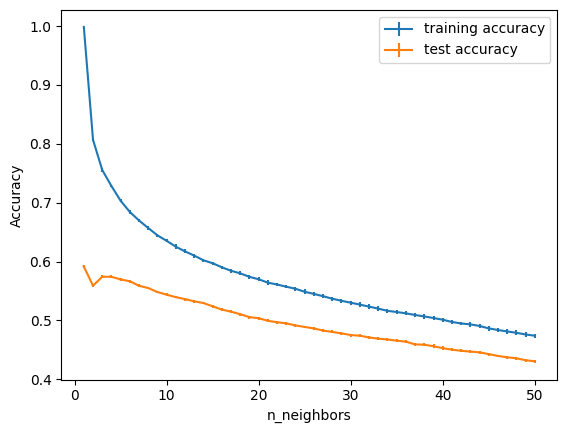

In [38]:
plt.errorbar(neighbors_settings, lahat_training.mean(axis=1),
             yerr=lahat_training.std(axis=1)/2, label="training accuracy")
plt.errorbar(neighbors_settings, lahat_test.mean(axis=1),
             yerr=lahat_test.std(axis=1)/6, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [39]:
print("Best test set mean accuracy: {:.2f}%".format(lahat_test.mean(axis = 1).max() * 100))
print("For k = {}".format(lahat_test.mean(axis = 1).argmax() + 1))

Best test set mean accuracy: 59.16%
For k = 1


### Sampling Technique: Synthetic Minority Over-sampling Technique

In [76]:
df

,haplogroup,number of haplotypes,total frequency,sampleID,population,frequency,DYS576,DYS389 I,DYS635,DYS389 II,...,median_deviation,skewness_proxy,fast_var,slow_stability,fast_slow_ratio,heterogeneity_index,DYS385a_DYS385b_diff,weighted_mean,weighted_var,major_clade
0,C2b1a1a,4.0,1.0,HLM100,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,31.0,...,0.364254,-0.233999,-0.307542,0.130736,-0.556001,-0.988248,8.0,0.214451,-0.601452,C
1,C2b1a1a,4.0,1.0,HHM158,Hohhot[Mongolian],1.0,19.0,14.0,22.0,30.0,...,1.079324,-0.974406,-0.475979,-0.918693,-0.849838,-1.165320,6.0,0.403783,-0.601119,C
2,C2b1a1a,4.0,1.0,ODM030,Ordos[Mongolian],1.0,18.0,14.0,21.0,31.0,...,0.443706,-0.317377,-0.135520,0.130736,-0.556001,-0.944240,8.0,0.088229,-0.551222,C
3,C2b1a1a,4.0,1.0,HLM178,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,30.0,...,1.238229,-1.128786,-0.447309,-0.918693,-1.131787,-1.199756,6.0,0.025118,-0.927049,C
4,O2a2b1a1a1a4a1,6.0,1.0,HHM088,Hohhot[Mongolian],1.0,18.0,12.0,20.0,29.0,...,2.430013,-2.363469,-0.002920,-1.078968,-0.849838,-1.913031,4.0,-0.353548,-0.841999,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4059,O2a1c1a1a1,14.0,1.0,HaiN153(Han),Han,1.0,20.0,12.0,20.0,28.0,...,-1.304243,1.099067,0.208523,0.008390,0.436551,0.809831,0.0,0.403783,0.809531,O
4060,O2a1c1a1a1,14.0,1.0,GD-16(Han),Han,1.0,18.0,12.0,21.0,28.0,...,-0.033007,-0.139212,0.255112,0.276971,1.703962,0.698609,7.0,1.602891,1.648473,O
4061,O2a1c1a1a1,14.0,1.0,JX-82(Han),Han,1.0,19.0,12.0,21.0,28.0,...,1.794395,-1.824160,0.599156,0.276971,1.703962,0.116455,7.0,1.476669,1.441270,O
4062,O2a1c1a1a1,14.0,1.0,HaiN139(Han),Han,1.0,16.0,14.0,21.0,29.0,...,0.602611,-0.571578,-0.346963,-0.333996,-1.061300,-0.233608,6.0,-0.416659,-0.875249,O


#### Step 1. Data preprocessing to include mutation-aware feature engineering

In [80]:
# ======================================================
# 3. MUTATION-AWARE FEATURE ENGINEERING (Final Extended + Normalized)
# ======================================================

# ------------------------------------------------------
# Define Yfiler Plus mutation-rate groups (canonical names)
# ------------------------------------------------------
fast_loci = ["DYS570", "DYS576", "DYS458", "DYS449", "DYS627", "DYS481"]
intermediate_loci = [
    "DYS385a", "DYS385b", "DYS533", "DYS19", "DYS391",
    "DYS518", "DYS635", "DYS390", "DYS392", "DYS393"
]
slow_loci = [
    "DYS438", "DYS437", "DYS439", "DYS389I", "DYS389II",
    "DYS460", "DYS456", "Y_GATA_H4", "DYS448"
]

# ------------------------------------------------------
# Identify available STR columns
# ------------------------------------------------------
available_str_cols = [c for c in df.columns if any(k in c for k in ["DYS", "Y_GATA", "YGATA"])]
print(f"Detected {len(available_str_cols)} STR columns:", available_str_cols)

# ------------------------------------------------------
# Adjust loci lists to only include those present
# ------------------------------------------------------
fast_loci = [l for l in fast_loci if l in df.columns]
intermediate_loci = [l for l in intermediate_loci if l in df.columns]
slow_loci = [l for l in slow_loci if l in df.columns]
str_cols = list(set(fast_loci + intermediate_loci + slow_loci))

print(f"\nUsing {len(str_cols)} STR loci after filtering:")
print(str_cols)

# ------------------------------------------------------
# Ensure numeric STR data
# ------------------------------------------------------
df[str_cols] = df[str_cols].apply(pd.to_numeric, errors="coerce")

# ------------------------------------------------------
# Remove haplogroups with only one sample
# ------------------------------------------------------
hap_col = df.columns[0]
counts = df[hap_col].value_counts()
df = df[df[hap_col].isin(counts[counts > 1].index)].copy()

# ------------------------------------------------------
# Compute haplogroup centroids
# ------------------------------------------------------
centroids = df.groupby(hap_col)[str_cols].mean()

# ------------------------------------------------------
# L1 distance to haplogroup centroid
# ------------------------------------------------------
def l1_to_centroid(row):
    hg = row[hap_col]
    if hg not in centroids.index:
        return np.nan
    centroid = centroids.loc[hg]
    return np.abs(row[str_cols] - centroid).sum()

df["l1_centroid"] = df.apply(l1_to_centroid, axis=1)

# ------------------------------------------------------
# Weighted L1 (fast=3, intermediate=2, slow=1)
# ------------------------------------------------------
weights = {l: 3 for l in fast_loci}
weights.update({l: 2 for l in intermediate_loci})
weights.update({l: 1 for l in slow_loci})

df["weighted_l1_centroid"] = df.apply(
    lambda r: sum(
        abs(r[c] - centroids.loc[r[hap_col], c]) * weights.get(c, 2)
        for c in str_cols if c in centroids.columns
    ),
    axis=1
)

# ------------------------------------------------------
# Global allele statistics
# ------------------------------------------------------
df["allele_sum"] = df[str_cols].sum(axis=1)
df["allele_var"] = df[str_cols].var(axis=1)
df["allele_mean"] = df[str_cols].mean(axis=1)
df["allele_std"] = df[str_cols].std(axis=1)

# ------------------------------------------------------
# Median-based and skewness proxies
# ------------------------------------------------------
df["allele_median"] = df[str_cols].median(axis=1)
df["median_deviation"] = df["allele_median"] - df["allele_mean"]
df["skewness_proxy"] = (df["allele_mean"] - df["allele_median"]) / (df["allele_std"] + 1e-9)

# ------------------------------------------------------
# Mutation-category-specific variation
# ------------------------------------------------------
if fast_loci:
    df["fast_var"] = df[fast_loci].var(axis=1)
else:
    df["fast_var"] = np.nan

if slow_loci:
    df["slow_stability"] = -df[slow_loci].sub(df[slow_loci].mean(), axis=1).abs().sum(axis=1)
else:
    df["slow_stability"] = np.nan

# ------------------------------------------------------
# Fast-to-slow ratio and heterogeneity index
# ------------------------------------------------------
if fast_loci and slow_loci:
    df["fast_slow_ratio"] = df[fast_loci].mean(axis=1) / (df[slow_loci].mean(axis=1) + 1e-9)
else:
    df["fast_slow_ratio"] = np.nan

df["heterogeneity_index"] = df["allele_std"] / (df["allele_mean"] + 1e-9)

# ------------------------------------------------------
# Pairwise differential features
# ------------------------------------------------------
pair_loci = [("DYS385a", "DYS385b"), ("DYS389I", "DYS389II")]
for a, b in pair_loci:
    if a in df.columns and b in df.columns:
        df[f"{a}_{b}_diff"] = (df[a] - df[b]).abs()

# ------------------------------------------------------
# Mutation-weighted summary statistics
# ------------------------------------------------------
def weighted_summary(row):
    vals = []
    for locus in str_cols:
        weight = weights.get(locus, 2)
        vals.append(row[locus] * weight)
    return np.mean(vals), np.var(vals)

df["weighted_mean"], df["weighted_var"] = zip(*df.apply(weighted_summary, axis=1))

# ------------------------------------------------------
# Normalize all engineered numeric features
# ------------------------------------------------------
scaler = StandardScaler()
to_scale = [
    "l1_centroid", "weighted_l1_centroid", "allele_sum", "allele_mean", "allele_std",
    "allele_var", "fast_var", "slow_stability", "fast_slow_ratio", "heterogeneity_index",
    "weighted_mean", "weighted_var", "median_deviation", "skewness_proxy"
]
df[to_scale] = scaler.fit_transform(df[to_scale])

# ------------------------------------------------------
# Summary of added features
# ------------------------------------------------------
added_features = to_scale + [
    f"{a}_{b}_diff" for a, b in pair_loci if a in df.columns and b in df.columns
]

print("\nMutation-aware and derived features added successfully:")
print(added_features)


Detected 26 STR columns: ['DYS576', 'DYS389 I', 'DYS635', 'DYS389 II', 'DYS627', 'DYS460', 'DYS458', 'DYS19', 'DYS448', 'DYS391', 'DYS456', 'DYS390', 'DYS438', 'DYS392', 'DYS518', 'DYS570', 'DYS437', 'DYS385a', 'DYS385b', 'DYS449', 'DYS393', 'DYS439', 'DYS481', 'DYS576a', 'DYS576b', 'DYS533']

Using 22 STR loci after filtering:
['DYS392', 'DYS385b', 'DYS437', 'DYS393', 'DYS439', 'DYS458', 'DYS456', 'DYS460', 'DYS385a', 'DYS576', 'DYS518', 'DYS481', 'DYS438', 'DYS391', 'DYS448', 'DYS635', 'DYS533', 'DYS19', 'DYS570', 'DYS449', 'DYS390', 'DYS627']

Mutation-aware and derived features added successfully:
['l1_centroid', 'weighted_l1_centroid', 'allele_sum', 'allele_mean', 'allele_std', 'allele_var', 'fast_var', 'slow_stability', 'fast_slow_ratio', 'heterogeneity_index', 'weighted_mean', 'weighted_var', 'median_deviation', 'skewness_proxy', 'DYS385a_DYS385b_diff']


### Step 2. Create and Train Model

#### Original Model without SMOTE

In [11]:
# ======================================================
# 1. PREPARE DATA
# ======================================================
hap_col = df.columns[0]
df["major_clade"] = df[hap_col].str.extract(r"^([A-Z])")

X = df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce")
y_major = df["major_clade"]
y_full = df[hap_col]

# ======================================================
# 2. SPLIT DATA (Singleton-safe)
# ======================================================
mask = y_major.value_counts()[y_major].values > 1
X_filtered, y_filtered = X[mask], y_major[mask]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx, test_idx in sss.split(X_filtered, y_filtered):
    X_train, X_test = X_filtered.iloc[train_idx], X_filtered.iloc[test_idx]
    y_train, y_test = y_filtered.iloc[train_idx], y_filtered.iloc[test_idx]

X_train = pd.concat([X_train, X[~mask]])
y_train = pd.concat([y_train, y_major[~mask]])

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# ======================================================
# 3. DEFINE MODEL BUILDERS
# ======================================================
def make_rf():
    return RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        min_samples_leaf=5,
        min_samples_split=10,
        max_features="sqrt",
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    )


def make_lgbm():
    return LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=20,
        max_depth=7,
        min_data_in_leaf=20,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        reg_lambda=2.0,
        reg_alpha=1.0,
        is_unbalance=True,
        n_jobs=-1,
        random_state=42,
        verbose=-1,
    )


# ======================================================
# 4. K-FOLD CV FUNCTION
# ======================================================
def crossval_model(model_builder, X, y, k=5):
    """Performs Stratified K-Fold CV and returns mean train/test macro-F1 and accuracy."""
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    f1_train_scores, f1_test_scores = [], []
    acc_train_scores, acc_test_scores = [], []

    for train_idx, test_idx in skf.split(X, y):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        model = model_builder()
        model.fit(X_tr, y_tr)

        y_pred_train = model.predict(X_tr)
        y_pred_test = model.predict(X_te)

        f1_train = f1_score(y_tr, y_pred_train, average="macro", zero_division=0)
        f1_test = f1_score(y_te, y_pred_test, average="macro", zero_division=0)
        acc_train = accuracy_score(y_tr, y_pred_train)
        acc_test = accuracy_score(y_te, y_pred_test)

        f1_train_scores.append(f1_train)
        f1_test_scores.append(f1_test)
        acc_train_scores.append(acc_train)
        acc_test_scores.append(acc_test)

    return (
        np.mean(f1_train_scores),
        np.mean(f1_test_scores),
        np.mean(acc_train_scores),
        np.mean(acc_test_scores),
    )


# ======================================================
# 5. MAJOR CLADE COMPARISON (K-FOLD)
# ======================================================
rf_f1_train, rf_f1_test, rf_acc_train, rf_acc_test = crossval_model(
    make_rf, X_train, y_train
)
lgbm_f1_train, lgbm_f1_test, lgbm_acc_train, lgbm_acc_test = crossval_model(
    make_lgbm, X_train, y_train
)

print("\nMAJOR CLADE (K-Fold Average Metrics)")
print(f"Random Forest - F1_macro_train: {rf_f1_train:.3f}, F1_macro_test: {rf_f1_test:.3f}, Acc_train: {rf_acc_train:.3f}, Acc_test: {rf_acc_test:.3f}")
print(f"LightGBM      - F1_macro_train: {lgbm_f1_train:.3f}, F1_macro_test: {lgbm_f1_test:.3f}, Acc_train: {lgbm_acc_train:.3f}, Acc_test: {lgbm_acc_test:.3f}")

# ======================================================
# 6. SUBCLADE COMPARISON (PER MAJOR CLADE, K-FOLD)
# ======================================================
sub_results = []

for clade in df["major_clade"].unique():
    sub_df = df[df["major_clade"] == clade]
    sub_X = sub_df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce")
    sub_y = sub_df[hap_col]

    if sub_y.nunique() < 3 or len(sub_y) < 20:
        print(f"Skipping {clade}: only {len(sub_y)} samples, {sub_y.nunique()} subclades.")
        continue

    rf_f1_train, rf_f1_test, rf_acc_train, rf_acc_test = crossval_model(
        make_rf, sub_X, sub_y
    )
    lgbm_f1_train, lgbm_f1_test, lgbm_acc_train, lgbm_acc_test = crossval_model(
        make_lgbm, sub_X, sub_y
    )

    sub_results.append(
        {
            "Clade": clade,
            "RF_F1_Train": rf_f1_train,
            "RF_F1_Test": rf_f1_test,
            "RF_Acc_Train": rf_acc_train,
            "RF_Acc_Test": rf_acc_test,
            "LGBM_F1_Train": lgbm_f1_train,
            "LGBM_F1_Test": lgbm_f1_test,
            "LGBM_Acc_Train": lgbm_acc_train,
            "LGBM_Acc_Test": lgbm_acc_test,
            "RF_Overfit": rf_f1_train - rf_f1_test,
            "LGBM_Overfit": lgbm_f1_train - lgbm_f1_test,
            "n_classes": sub_y.nunique(),
            "n_samples": len(sub_y),
        }
    )

    print(
        f"Subclade {clade} - "
        f"RF F1_macro_test: {rf_f1_test:.3f}, Acc_test: {rf_acc_test:.3f} | "
        f"LGBM F1_macro_test: {lgbm_f1_test:.3f}, Acc_test: {lgbm_acc_test:.3f}"
    )

# ======================================================
# 7. SUMMARIZE RESULTS
# ======================================================
sub_results_df = pd.DataFrame(sub_results)
print("\nHierarchical K-Fold Model Comparison Summary:\n")
display(sub_results_df.sort_values("LGBM_F1_Test", ascending=False))

print("\nK-Fold hierarchical comparison complete.")

Train size: 3027, Test size: 1010

MAJOR CLADE (K-Fold Average Metrics)
Random Forest - F1_macro_train: 0.980, F1_macro_test: 0.841, Acc_train: 0.982, Acc_test: 0.969
LightGBM      - F1_macro_train: 0.984, F1_macro_test: 0.865, Acc_train: 1.000, Acc_test: 0.976
Subclade C - RF F1_macro_test: 0.561, Acc_test: 0.719 | LGBM F1_macro_test: 0.552, Acc_test: 0.732
Subclade O - RF F1_macro_test: 0.462, Acc_test: 0.516 | LGBM F1_macro_test: 0.504, Acc_test: 0.617
Subclade D - RF F1_macro_test: 0.583, Acc_test: 0.759 | LGBM F1_macro_test: 0.522, Acc_test: 0.752
Subclade Q - RF F1_macro_test: 0.533, Acc_test: 0.668 | LGBM F1_macro_test: 0.411, Acc_test: 0.571
Subclade R - RF F1_macro_test: 0.584, Acc_test: 0.690 | LGBM F1_macro_test: 0.526, Acc_test: 0.744
Subclade N - RF F1_macro_test: 0.590, Acc_test: 0.743 | LGBM F1_macro_test: 0.571, Acc_test: 0.792
Subclade J - RF F1_macro_test: 0.733, Acc_test: 0.817 | LGBM F1_macro_test: 0.692, Acc_test: 0.789
Skipping G: only 18 samples, 5 subclades.
Ski

,Clade,RF_F1_Train,RF_F1_Test,RF_Acc_Train,RF_Acc_Test,LGBM_F1_Train,LGBM_F1_Test,LGBM_Acc_Train,LGBM_Acc_Test,RF_Overfit,LGBM_Overfit,n_classes,n_samples
6,J,0.940411,0.732864,0.942312,0.817143,0.981125,0.692363,0.980752,0.788571,0.207547,0.288762,6,104
5,N,0.932171,0.589923,0.932140,0.743466,0.935188,0.571053,0.995349,0.791894,0.342247,0.364135,13,269
0,C,0.879108,0.560553,0.897706,0.719266,0.963091,0.551525,0.991284,0.732110,0.318555,0.411566,29,545
4,R,0.874608,0.583944,0.856758,0.689899,0.924678,0.525882,0.979925,0.744444,0.290664,0.398795,14,274
2,D,0.923001,0.583066,0.916667,0.759259,0.869707,0.522060,0.979630,0.751852,0.339935,0.347646,21,270
1,O,0.752191,0.462203,0.739955,0.515693,0.981081,0.503967,0.996965,0.616578,0.289988,0.477114,90,2389
3,Q,0.943429,0.533363,0.920320,0.668421,0.825564,0.410635,0.923021,0.570760,0.410067,0.414929,7,91



K-Fold hierarchical comparison complete.


#### New Model with SMOTE

In [38]:
df

,haplogroup,number of haplotypes,total frequency,sampleID,population,frequency,DYS576,DYS389 I,DYS635,DYS389 II,...,allele_median,median_deviation,skewness_proxy,fast_var,slow_stability,fast_slow_ratio,heterogeneity_index,DYS385a_DYS385b_diff,weighted_mean,weighted_var
0,C2b1a1a,4.0,1.0,HLM100,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,31.0,...,16.0,0.364254,-0.233999,-0.307542,0.130736,-0.556001,-0.988248,8.0,0.214451,-0.601452
1,C2b1a1a,4.0,1.0,HHM158,Hohhot[Mongolian],1.0,19.0,14.0,22.0,30.0,...,16.5,1.079324,-0.974406,-0.475979,-0.918693,-0.849838,-1.165320,6.0,0.403783,-0.601119
2,C2b1a1a,4.0,1.0,ODM030,Ordos[Mongolian],1.0,18.0,14.0,21.0,31.0,...,16.0,0.443706,-0.317377,-0.135520,0.130736,-0.556001,-0.944240,8.0,0.088229,-0.551222
3,C2b1a1a,4.0,1.0,HLM178,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,30.0,...,16.5,1.238229,-1.128786,-0.447309,-0.918693,-1.131787,-1.199756,6.0,0.025118,-0.927049
4,O2a2b1a1a1a4a1,6.0,1.0,HHM088,Hohhot[Mongolian],1.0,18.0,12.0,20.0,29.0,...,17.0,2.430013,-2.363469,-0.002920,-1.078968,-0.849838,-1.913031,4.0,-0.353548,-0.841999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4059,O2a1c1a1a1,14.0,1.0,HaiN153(Han),Han,1.0,20.0,12.0,20.0,28.0,...,15.0,-1.304243,1.099067,0.208523,0.008390,0.436551,0.809831,0.0,0.403783,0.809531
4060,O2a1c1a1a1,14.0,1.0,GD-16(Han),Han,1.0,18.0,12.0,21.0,28.0,...,16.0,-0.033007,-0.139212,0.255112,0.276971,1.703962,0.698609,7.0,1.602891,1.648473
4061,O2a1c1a1a1,14.0,1.0,JX-82(Han),Han,1.0,19.0,12.0,21.0,28.0,...,17.0,1.794395,-1.824160,0.599156,0.276971,1.703962,0.116455,7.0,1.476669,1.441270
4062,O2a1c1a1a1,14.0,1.0,HaiN139(Han),Han,1.0,16.0,14.0,21.0,29.0,...,16.0,0.602611,-0.571578,-0.346963,-0.333996,-1.061300,-0.233608,6.0,-0.416659,-0.875249


Applying SMOTE on the Major Clades

In [81]:
# ======================================================
# 1. PREPARE DATA
# ======================================================
hap_col = df.columns[0]
df["major_clade"] = df[hap_col].str.extract(r"^([A-Z])")

X = df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce").fillna(0)
y_major = df["major_clade"]
y_full = df[hap_col]

# ======================================================
# 2. SPLIT DATA (Singleton-safe)
# ======================================================
mask = y_major.value_counts()[y_major].values > 1
X_filtered, y_filtered = X[mask], y_major[mask]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx, test_idx in sss.split(X_filtered, y_filtered):
    X_train, X_test = X_filtered.iloc[train_idx], X_filtered.iloc[test_idx]
    y_train, y_test = y_filtered.iloc[train_idx], y_filtered.iloc[test_idx]

# Add singleton samples to training set
X_train = pd.concat([X_train, X[~mask]])
y_train = pd.concat([y_train, y_major[~mask]])

print(f"Train size (before SMOTE): {len(X_train)}, Test size: {len(X_test)}")

# ======================================================
# 2.1 APPLY SMOTE TO TRAINING DATA
# ======================================================
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42, k_neighbors=2)  # You can tune k_neighbors if needed

# Fit and resample training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Train size (after SMOTE): {len(X_train_res)}")
print("Class distribution before SMOTE:")
print(y_train.value_counts())
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())

# Use resampled data for all downstream steps
X_train = X_train_res
y_train = y_train_res

# ======================================================
# 3. DEFINE MODEL BUILDERS
# ======================================================
def make_rf():
    return RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        min_samples_leaf=5,
        min_samples_split=10,
        max_features="sqrt",
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    )


def make_lgbm():
    return LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=20,
        max_depth=7,
        min_data_in_leaf=20,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        reg_lambda=2.0,
        reg_alpha=1.0,
        is_unbalance=True,
        n_jobs=-1,
        random_state=42,
        verbose=-1,
    )


# ======================================================
# 4. K-FOLD CV FUNCTION
# ======================================================
def crossval_model(model_builder, X, y, k=5):
    """Performs Stratified K-Fold CV and returns mean train/test macro-F1 and accuracy."""
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    f1_train_scores, f1_test_scores = [], []
    acc_train_scores, acc_test_scores = [], []

    for train_idx, test_idx in skf.split(X, y):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        model = model_builder()
        model.fit(X_tr, y_tr)

        y_pred_train = model.predict(X_tr)
        y_pred_test = model.predict(X_te)

        f1_train = f1_score(y_tr, y_pred_train, average="macro", zero_division=0)
        f1_test = f1_score(y_te, y_pred_test, average="macro", zero_division=0)
        acc_train = accuracy_score(y_tr, y_pred_train)
        acc_test = accuracy_score(y_te, y_pred_test)

        f1_train_scores.append(f1_train)
        f1_test_scores.append(f1_test)
        acc_train_scores.append(acc_train)
        acc_test_scores.append(acc_test)

    return (
        np.mean(f1_train_scores),
        np.mean(f1_test_scores),
        np.mean(acc_train_scores),
        np.mean(acc_test_scores),
    )


# ======================================================
# 5. MAJOR CLADE COMPARISON (K-FOLD)
# ======================================================
rf_f1_train, rf_f1_test, rf_acc_train, rf_acc_test = crossval_model(
    make_rf, X_train, y_train
)
lgbm_f1_train, lgbm_f1_test, lgbm_acc_train, lgbm_acc_test = crossval_model(
    make_lgbm, X_train, y_train
)

print("\nMAJOR CLADE (K-Fold Average Metrics)")
print(f"Random Forest - F1_macro_train: {rf_f1_train:.3f}, F1_macro_test: {rf_f1_test:.3f}, Acc_train: {rf_acc_train:.3f}, Acc_test: {rf_acc_test:.3f}")
print(f"LightGBM      - F1_macro_train: {lgbm_f1_train:.3f}, F1_macro_test: {lgbm_f1_test:.3f}, Acc_train: {lgbm_acc_train:.3f}, Acc_test: {lgbm_acc_test:.3f}")

# ======================================================
# 6. SUBCLADE COMPARISON (PER MAJOR CLADE, K-FOLD)
# ======================================================
sub_results = []

for clade in df["major_clade"].unique():
    sub_df = df[df["major_clade"] == clade]
    sub_X = sub_df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce")
    sub_y = sub_df[hap_col]

    if sub_y.nunique() < 3 or len(sub_y) < 20:
        print(f"Skipping {clade}: only {len(sub_y)} samples, {sub_y.nunique()} subclades.")
        continue

    rf_f1_train, rf_f1_test, rf_acc_train, rf_acc_test = crossval_model(
        make_rf, sub_X, sub_y
    )
    lgbm_f1_train, lgbm_f1_test, lgbm_acc_train, lgbm_acc_test = crossval_model(
        make_lgbm, sub_X, sub_y
    )

    sub_results.append(
        {
            "Clade": clade,
            "RF_F1_Train": rf_f1_train,
            "RF_F1_Test": rf_f1_test,
            "RF_Acc_Train": rf_acc_train,
            "RF_Acc_Test": rf_acc_test,
            "LGBM_F1_Train": lgbm_f1_train,
            "LGBM_F1_Test": lgbm_f1_test,
            "LGBM_Acc_Train": lgbm_acc_train,
            "LGBM_Acc_Test": lgbm_acc_test,
            "RF_Overfit": rf_f1_train - rf_f1_test,
            "LGBM_Overfit": lgbm_f1_train - lgbm_f1_test,
            "n_classes": sub_y.nunique(),
            "n_samples": len(sub_y),
        }
    )

    print(
        f"Subclade {clade} - "
        f"RF F1_macro_test: {rf_f1_test:.3f}, Acc_test: {rf_acc_test:.3f} | "
        f"LGBM F1_macro_test: {lgbm_f1_test:.3f}, Acc_test: {lgbm_acc_test:.3f}"
    )

# ======================================================
# 7. SUMMARIZE RESULTS
# ======================================================
sub_results_df = pd.DataFrame(sub_results)
print("\nHierarchical K-Fold Model Comparison Summary:\n")
display(sub_results_df.sort_values("LGBM_F1_Test", ascending=False))

print("\nK-Fold hierarchical comparison complete.")


Train size (before SMOTE): 3027, Test size: 1010
Train size (after SMOTE): 23283
Class distribution before SMOTE:
major_clade
O    1791
C     409
R     205
N     202
D     202
J      78
Q      68
F      19
G      14
L      14
H      13
I       9
P       3
Name: count, dtype: int64

Class distribution after SMOTE:
major_clade
N    1791
O    1791
Q    1791
D    1791
C    1791
R    1791
G    1791
J    1791
P    1791
F    1791
H    1791
L    1791
I    1791
Name: count, dtype: int64

MAJOR CLADE (K-Fold Average Metrics)
Random Forest - F1_macro_train: 0.993, F1_macro_test: 0.992, Acc_train: 0.993, Acc_test: 0.992
LightGBM      - F1_macro_train: 1.000, F1_macro_test: 0.998, Acc_train: 1.000, Acc_test: 0.998
Subclade C - RF F1_macro_test: 0.561, Acc_test: 0.719 | LGBM F1_macro_test: 0.552, Acc_test: 0.732
Subclade O - RF F1_macro_test: 0.462, Acc_test: 0.516 | LGBM F1_macro_test: 0.504, Acc_test: 0.617
Subclade D - RF F1_macro_test: 0.583, Acc_test: 0.759 | LGBM F1_macro_test: 0.522, Acc_test

,Clade,RF_F1_Train,RF_F1_Test,RF_Acc_Train,RF_Acc_Test,LGBM_F1_Train,LGBM_F1_Test,LGBM_Acc_Train,LGBM_Acc_Test,RF_Overfit,LGBM_Overfit,n_classes,n_samples
6,J,0.940411,0.732864,0.942312,0.817143,0.981125,0.692363,0.980752,0.788571,0.207547,0.288762,6,104
5,N,0.932171,0.589923,0.932140,0.743466,0.935188,0.571053,0.995349,0.791894,0.342247,0.364135,13,269
0,C,0.879108,0.560553,0.897706,0.719266,0.963091,0.551525,0.991284,0.732110,0.318555,0.411566,29,545
4,R,0.874608,0.583944,0.856758,0.689899,0.924678,0.525882,0.979925,0.744444,0.290664,0.398795,14,274
2,D,0.923001,0.583066,0.916667,0.759259,0.869707,0.522060,0.979630,0.751852,0.339935,0.347646,21,270
1,O,0.752191,0.462203,0.739955,0.515693,0.981081,0.503967,0.996965,0.616578,0.289988,0.477114,90,2389
3,Q,0.943429,0.533363,0.920320,0.668421,0.825564,0.410635,0.923021,0.570760,0.410067,0.414929,7,91



K-Fold hierarchical comparison complete.


Applying SMOTE on the Subclades

In [84]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# ======================================================
# 1. K-FOLD CROSSVALIDATION UTILITY WITH SMOTE
# ======================================================
def crossval_f1(model_builder, X, y, k=5):
    """Run Stratified K-Fold CV with SMOTE and return average macro-F1 and accuracy (train/test)."""
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    f1_train_scores, f1_test_scores = [], []
    acc_train_scores, acc_test_scores = [], []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Apply SMOTE only on training data
        sm = SMOTE(random_state=42, k_neighbors=2)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

        model = model_builder()
        model.fit(X_train_res, y_train_res)
        y_pred_train = model.predict(X_train_res)
        y_pred_test = model.predict(X_test)

        # --- Macro F1 ---
        f1_train = f1_score(y_train_res, y_pred_train, average="macro", zero_division=0)
        f1_test = f1_score(y_test, y_pred_test, average="macro", zero_division=0)

        # --- Accuracy ---
        acc_train = accuracy_score(y_train_res, y_pred_train)
        acc_test = accuracy_score(y_test, y_pred_test)

        f1_train_scores.append(f1_train)
        f1_test_scores.append(f1_test)
        acc_train_scores.append(acc_train)
        acc_test_scores.append(acc_test)

    return (
        np.mean(f1_train_scores),
        np.mean(f1_test_scores),
        np.mean(acc_train_scores),
        np.mean(acc_test_scores)
    )

# ======================================================
# 2. DEFINE HYPERPARAMETER GRIDS
# ======================================================
rf_params = [
    {"max_depth": 6, "min_samples_leaf": 3},
    {"max_depth": 8, "min_samples_leaf": 5},
    {"max_depth": 10, "min_samples_leaf": 5},
    {"max_depth": 15, "min_samples_leaf": 5},
    {"max_depth": 20, "min_samples_leaf": 5},
    {"max_depth": 25, "min_samples_leaf": 5}
]

lgbm_params = [
    {"max_depth": 5, "num_leaves": 15, "min_data_in_leaf": 15, "reg_lambda": 1.0, "reg_alpha": 0.5},
    {"max_depth": 7, "num_leaves": 20, "min_data_in_leaf": 20, "reg_lambda": 2.0, "reg_alpha": 1.0},
    {"max_depth": 9, "num_leaves": 25, "min_data_in_leaf": 25, "reg_lambda": 3.0, "reg_alpha": 1.5},
    {"max_depth": 11, "num_leaves": 25, "min_data_in_leaf": 25, "reg_lambda": 3.0, "reg_alpha": 1.5},
    {"max_depth": 13, "num_leaves": 25, "min_data_in_leaf": 25, "reg_lambda": 3.0, "reg_alpha": 1.5},
    {"max_depth": 15, "num_leaves": 25, "min_data_in_leaf": 25, "reg_lambda": 3.0, "reg_alpha": 1.5},
]


# ======================================================
# 3. LOOP THROUGH MAJOR CLADES
# ======================================================
sub_results = []

for clade in df["major_clade"].unique():
    sub_df = df[df["major_clade"] == clade]
    sub_X = sub_df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce").fillna(0)
    sub_y = sub_df[hap_col]

    # Skip small clades
    if sub_y.nunique() < 3 or len(sub_y) < 20:
        print(f"Skipping {clade}: only {len(sub_y)} samples, {sub_y.nunique()} subclades.")
        continue

    print(f"\nEvaluating clade {clade} ({len(sub_y)} samples, {sub_y.nunique()} classes)...")

    best_rf = {"f1_test": 0, "params": None}
    best_lgbm = {"f1_test": 0, "params": None}

    # ======================================================
    # Random Forest parameter tuning with K-Fold CV
    # ======================================================
    for p in rf_params:
        def rf_builder():
            return RandomForestClassifier(
                n_estimators=300,
                max_depth=p["max_depth"],
                min_samples_leaf=p["min_samples_leaf"],
                min_samples_split=10,
                max_features="sqrt",
                class_weight="balanced",
                n_jobs=-1,
                random_state=42
            )

        rf_f1_train, rf_f1_test, rf_acc_train, rf_acc_test = crossval_f1(rf_builder, sub_X, sub_y, k=5)
        if rf_f1_test > best_rf["f1_test"]:
            best_rf.update({
                "f1_train": rf_f1_train,
                "f1_test": rf_f1_test,
                "acc_train": rf_acc_train,
                "acc_test": rf_acc_test,
                "params": p
            })

    # ======================================================
    # LightGBM parameter tuning with K-Fold CV
    # ======================================================
    for p in lgbm_params:
        def lgbm_builder():
            return LGBMClassifier(
                n_estimators=500,
                learning_rate=0.05,
                max_depth=p["max_depth"],
                num_leaves=p["num_leaves"],
                min_data_in_leaf=p["min_data_in_leaf"],
                reg_lambda=p["reg_lambda"],
                reg_alpha=p["reg_alpha"],
                feature_fraction=0.8,
                bagging_fraction=0.8,
                bagging_freq=5,
                is_unbalance=True,
                n_jobs=-1,
                random_state=42,
                verbose=-1
            )

        lgbm_f1_train, lgbm_f1_test, lgbm_acc_train, lgbm_acc_test = crossval_f1(lgbm_builder, sub_X, sub_y, k=5)
        if lgbm_f1_test > best_lgbm["f1_test"]:
            best_lgbm.update({
                "f1_train": lgbm_f1_train,
                "f1_test": lgbm_f1_test,
                "acc_train": lgbm_acc_train,
                "acc_test": lgbm_acc_test,
                "params": p
            })

    # ======================================================
    # Record best results per clade
    # ======================================================
    sub_results.append({
        "Clade": clade,
        "RF_F1_Train": best_rf["f1_train"],
        "RF_F1_Test": best_rf["f1_test"],
        "RF_Acc_Train": best_rf["acc_train"],
        "RF_Acc_Test": best_rf["acc_test"],
        "RF_Overfit": best_rf["f1_train"] - best_rf["f1_test"],
        "RF_Params": best_rf["params"],
        "LGBM_F1_Train": best_lgbm["f1_train"],
        "LGBM_F1_Test": best_lgbm["f1_test"],
        "LGBM_Acc_Train": best_lgbm["acc_train"],
        "LGBM_Acc_Test": best_lgbm["acc_test"],
        "LGBM_Overfit": best_lgbm["f1_train"] - best_lgbm["f1_test"],
        "LGBM_Params": best_lgbm["params"],
        "n_classes": sub_y.nunique(),
        "n_samples": len(sub_y)
    })

    print(
        f"Subclade {clade} — "
        f"RF F1_test: {best_rf['f1_test']:.3f}, Acc_test: {best_rf['acc_test']:.3f} ({best_rf['params']}), "
        f"LGBM F1_test: {best_lgbm['f1_test']:.3f}, Acc_test: {best_lgbm['acc_test']:.3f} ({best_lgbm['params']})"
    )

# ======================================================
# 4. SUMMARIZE RESULTS
# ======================================================
sub_results_df = pd.DataFrame(sub_results)
display(sub_results_df.sort_values("LGBM_F1_Test", ascending=False))

print("\nSubclade-level tuning with K-Fold CV complete.")


Evaluating clade C (545 samples, 29 classes)...


ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 3, n_samples_fit = 2, n_samples = 2

### Sampling Technique: Adaptive Synthetic Sampling